<a href="https://colab.research.google.com/github/HedersonSantos/Noticias/blob/main/BERT/BERTimbau_noticias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install transformers

     |████████████████████████████████| 2.9 MB 5.2 MB/s 
     |████████████████████████████████| 895 kB 37.2 MB/s 
     |████████████████████████████████| 56 kB 4.6 MB/s 
     |████████████████████████████████| 3.3 MB 33.7 MB/s 
     |████████████████████████████████| 596 kB 52.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
!pip install torch==1.8.1 torchvision==0.9.1 torchaudio==0.8.

     |████████████████████████████████| 804.1 MB 1.9 kB/s 
     |████████████████████████████████| 17.4 MB 206 kB/s 
     |████████████████████████████████| 1.9 MB 47.1 MB/s 
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of <Python from Requires-Python> to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
ERROR: Cannot install torch==1.8.1, torchaudio==0.8.0 and torchvision==0.9.1 because these package versions have conflicting dependencies.

The conflict is caused by:
    The user requested torch==1.8.1
    torchvision 0.9.1 depends on torch==1.8.1
    torchaudio 0.8.0 depends on torch==1.8.0

To fix this you could try to:
1. loosen the range of package versions you'

In [3]:
!nvidia-smi

Tue Oct 19 11:08:59 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
# Libraries

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from datetime import datetime
from google.colab import files, drive
import io, os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 10)

# Preliminaries

from torchtext.legacy.data import Field, TabularDataset, BucketIterator, Iterator

# Models

import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig
from transformers import AutoTokenizer  # Or BertTokenizer
from transformers import AutoModelForPreTraining  # Or BertForPreTraining for loading pretraining heads
from transformers import AutoModel  # or BertModel, for BERT without pretraining heads

# Training

import torch.optim as optim

# Evaluation
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, precision_score, \
                            recall_score,  f1_score, confusion_matrix, \
                            plot_confusion_matrix, classification_report, \
                            balanced_accuracy_score, cohen_kappa_score, matthews_corrcoef
import seaborn as sns

In [5]:
tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')
model = AutoModel.from_pretrained('neuralmind/bert-base-portuguese-cased')

Downloading:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/647 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/205k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/Colab\ Notebooks
source_folder = './amostra_news_integrada/amostra_' #'/content'
destination_folder = './bertimbau_resp' #'/content'

Mounted at /gdrive
/gdrive/My Drive/Colab Notebooks


In [7]:
class BERTimbau_Noticias():

    def __init__(self, tokenizer, max_seq_length=512, 
               bs=8, lr=1e-6, qtd_categorias=10,
               source_folder = './amostra_news_integrada/amostra_', 
               destination_folder = './bertimbau_resp'):
      self.MAX_SEQ_LEN = max_seq_length #limita os artigos em 128 tokens. BERTimbau base é limitado em 512 tokens por texto.
      self.PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
      self.UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)
      self.tokenizer = tokenizer
      self.bs = bs
      self.lr = lr
      self.qtd_categorias=qtd_categorias
      self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
      self.source_folder = source_folder
      self.destination_folder= destination_folder
    

    def montaFields(self):
      '''Define a estrutura do registro que será utilizada para construir os datasets de treinamento, validação e teste. 
        Também faz a ligação entre o tokenizador BERTimbau e as sequências de texto. 
        Esta estrutura será submetida ao tokenizaAmostra.
        Retorna uma lista contendo o label_field, text_field e o fields que é uma lista de tuplas com text e label'''
      # Fields - use_vocab=False  e tokenizer.encode permite que utilizemos os tokens do BERTimbau.
      label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
      text_field = Field(use_vocab=False, tokenize=self.tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                    fix_length=self.MAX_SEQ_LEN, pad_token=self.PAD_INDEX, unk_token=self.UNK_INDEX)
      fields = [('text', text_field),('label', label_field)]
      return [label_field, text_field, fields]

    def tokenizaAmostra(self, source_folder, soTeste=False):
      ''' Constroi os dataset de treino, validação e teste a partir de csv independentes disponibilizados no caminho source_folder e utilizando
          a estrutura de registro definida em fields, transformando a sequência de textos em sequência de tokens.
          Depois monta os BuckIterator de treino, validação e teste conforme definição do tamanho do bach size.
          Retorna uma lista de Iterators: treino, validação e teste.
          '''    
      #Fields
      label_field, text_field, fields = self.montaFields()
      # TabularDataset
      train, valid, test = TabularDataset.splits(path=source_folder, train='train.csv', validation='valid.csv',
                                                test='test.csv', format='CSV', fields=fields, skip_header=True)
      # Iterators

      train_iter, valid_iter = None, None
      test_iter = Iterator(test, batch_size=self.bs, device=self.device, train=False, shuffle=False, sort=False)
      if soTeste == False:
        train_iter = BucketIterator(train, batch_size=self.bs, sort_key=lambda x: len(x.text),
                                  device=self.device, train=True, sort=True, sort_within_batch=True)
        valid_iter = BucketIterator(valid, batch_size=self.bs, sort_key=lambda x: len(x.text),
                                  device=self.device, train=True, sort=True, sort_within_batch=True)
      return [train_iter, valid_iter, test_iter]

    def save_checkpoint(self,save_path, model, valid_loss):

      if save_path == None:
          return
      
      state_dict = {'model_state_dict': model.state_dict(),
                    'valid_loss': valid_loss}
      
      torch.save(state_dict, save_path)
      print(f'Model saved to ==> {save_path}')

    def load_checkpoint(self,load_path, model):
      
      if load_path==None:
          return
      
      state_dict = torch.load(load_path, map_location=self.device)
      print(f'Model loaded from <== {load_path}')
      
      model.load_state_dict(state_dict['model_state_dict'])
      return state_dict['valid_loss']


    def save_metrics(self,save_path, train_loss_list, valid_loss_list, global_steps_list, valid_accuracy, valid_precision):

      if save_path == None:
          return
      
      state_dict = {'train_loss_list': train_loss_list,
                    'valid_loss_list': valid_loss_list,
                    'global_steps_list': global_steps_list,
                    'valid_accuracy' : valid_accuracy,
                    'valid_precision': valid_precision}
      
      torch.save(state_dict, save_path)
      print(f'Model saved to ==> {save_path}')


    def load_metrics(self,load_path):

      if load_path==None:
          return
      
      state_dict = torch.load(load_path, map_location=processo.device)
      print(f'Model loaded from <== {load_path}')
      
      return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list'], state_dict['valid_accuracy'], state_dict['valid_precision']

    def save_embedding(self,save_path, embedding):

      if save_path == None:
          return
      
      emb_dict = {'_': embedding}
      
      torch.save(emb_dict, save_path)
      print(f'Embedding saved to ==> {save_path}')

    def load_embedding(self,load_path):

      if load_path==None:
          return
      
      emb_dict = torch.load(load_path, map_location=self.device)
      print(f'Embedding loaded from <== {load_path}')
      
      return emb_dict

    def create_directory(self,path, directory):
      try:
        os.makedirs(path + '/' + directory)
      except FileExistsError:
        # directory already exists
        pass
      
    def train(self, model,
          optimizer,
          train_loader ,
          valid_loader ,
          eval_every ,
          file_path ,
          criterion = nn.CrossEntropyLoss(), #nn.BCELoss(),
          num_epochs = 5,
          best_valid_loss = float("Inf")):
    
    
      print('1 - inicializando variávies')
      # initialize running values
      running_loss = 0.0
      valid_running_loss = 0.0
      global_step = 0
      train_loss_list = []
      valid_loss_list = []
      global_steps_list = []
      y_pred, y_true, valid_accuracy, valid_precision = [],[],[],[]
      # training loop
      print('1 - inicializando treinamento')
      model.train() #habilita os valores dos pesos do modelo para treinamento
      for epoch in range(num_epochs):
          X = []  
          for (text, labels), _ in train_loader:
              labels = labels.type(torch.LongTensor)  #carrega as categorias para pytorch         
              labels = labels.to(self.device) # disponibiliza para as GPU
              text = text.type(torch.LongTensor) #carrega os tokens do texto para pytorch        
              text = text.to(self.device) #disponibiliza para as GPU
              output = model(text, labels) #efetua o treinamento no modelo bert carregado
              loss, _ = output #obtem o valor da função loss do texto treinado

              optimizer.zero_grad() #limpa os gradientes do último treino (zera tudo)
              loss.backward() #calcula a derivada da função perda em relação aos parâmetros
              optimizer.step() #atualiza os pesos fazendo com que o otimizador dê um passo com base no gradiente dos parâmetros

              # update running values
              running_loss += loss.item() #acumula o valor da função loss
              global_step += 1
              #X.extend(_.tolist())
              # evaluation step - roda o modelo para o token de validação, obtém o valor da função loss e tira a média para o treinamento e validação.
              if global_step % eval_every == 0:
                  model.eval() # seta as camadas dropout e batch normalization 
                  with torch.no_grad():                    
                    
                      # validation loop
                      for (text,labels), _ in valid_loader:
                          text = text.type(torch.LongTensor)  
                          text = text.to(self.device)
                          labels = labels.type(torch.LongTensor)           
                          labels = labels.to(self.device)
                          
                          output = model(text, labels)
                          loss, saida = output
                          
                          valid_running_loss += loss.item()
                          y_pred.extend(torch.argmax(saida, 1).tolist())  #obtem do pytorch de saída do modelo o valor predito.
                          y_true.extend(labels.tolist()) #obtem do pytorch de teste  valor real.
                          

                      

                  # evaluation
                  average_train_loss = running_loss / eval_every
                  average_valid_loss = valid_running_loss / len(valid_loader)
                  train_loss_list.append(average_train_loss)
                  valid_loss_list.append(average_valid_loss)
                  global_steps_list.append(global_step)
                  valid_accuracy.append(accuracy_score(y_true, y_pred))
                  valid_precision.append(precision_score(y_true, y_pred, average='micro'))

                  # resetting running values
                  running_loss = 0.0                
                  valid_running_loss = 0.0
                  model.train()

                  # print progress
                  print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                        .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                                average_train_loss, average_valid_loss))
                  
                  # checkpoint
                  if best_valid_loss > average_valid_loss:
                      best_valid_loss = average_valid_loss
                      self.save_checkpoint(file_path + '/' + 'model.pt', model, best_valid_loss)
                      self.save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list, valid_accuracy, valid_precision)
                      
          #print(X)
          self.save_embedding(file_path + '/' + 'embedd.pt', X)
      self.save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list, valid_accuracy, valid_precision)
      #save_embedding(file_path + '/' + 'embedd.pt', X)
      print('Finished Training!')

    def calcula_GMean_multiclass(self,revocacao):
      revoc = np.array(revocacao)
      GMean = revoc.prod()**(1.0/len(revoc))
      return GMean 

    def calcula_especificidade(self, matriz_confusao):
      FP = matriz_confusao.sum(axis=0) - np.diag(matriz_confusao) 
      FN = matriz_confusao.sum(axis=1) - np.diag(matriz_confusao)
      VP = np.diag(matriz_confusao)
      VN = matriz_confusao.sum() - (FP + FN + VP)
      FP = FP.astype(float)
      FN = FN.astype(float)
      VP = VP.astype(float)
      VN = VN.astype(float)
      TVN = np.sum(VN)/(np.sum(VN) + np.sum(FP))
      return TVN
    
    def calcula_especificidade_porClasse(self, matriz_confusao):
      FP = matriz_confusao.sum(axis=0) - np.diag(matriz_confusao) 
      FN = matriz_confusao.sum(axis=1) - np.diag(matriz_confusao)
      VP = np.diag(matriz_confusao)
      VN = matriz_confusao.sum() - (FP + FN + VP)
      FP = FP.astype(float)
      FN = FN.astype(float)
      VP = VP.astype(float)
      VN = VN.astype(float)
      TVN = (VN)/(VN + FP)
      return TVN

    def elabora_relatorio_metricas(self, report, matriz_confusao):
      espec = calcula_especificidade_porClasse(matriz_confusao) # calcula o valor da especificidade para cada classe
      dfrep = pd.DataFrame(report).transpose() #transforma o conteúdo do classification_report em um dataframe pandas
      dfrep_a = dfrep[:-3].copy() # separa as métricas de cada classe do valor da acurácia geral do modelo
      dfrep_a['specificity'] = espec # inclui no dataframe o valor da especificidade
      dfrep_b  = dfrep[dfrep.index=='accuracy'].copy() #obtem do dataframe somente o valor da acurácia
      dfrep_b['specificity']=calcula_especificidade(matriz_confusao) # inclui o valor da especificidade geral de todas as classes
      metricas = ['precision', 'recall', 'specificity', 'f1-score', 'support'] #organiza as métricas na ordem desejada
      df = pd.concat([dfrep_a[metricas],dfrep_b[metricas]],sort=False) #concatena todos os valores em um único dataframe
      df['support'] = df['support'].astype('int')
      return df

    def elabora_relatorio_metricas(self, report, matriz_confusao):
      espec = calcula_especificidade_porClasse(matriz_confusao) # calcula o valor da especificidade para cada classe
      dfrep = pd.DataFrame(report).transpose() #transforma o conteúdo do classification_report em um dataframe pandas
      dfrep_a = dfrep[:-3].copy() # separa as métricas de cada classe do valor da acurácia geral do modelo
      dfrep_a['specificity'] = espec # inclui no dataframe o valor da especificidade
      dfrep_b  = dfrep[dfrep.index=='accuracy'].copy() #obtem do dataframe somente o valor da acurácia
      dfrep_b['specificity']=calcula_especificidade(matriz_confusao) # inclui o valor da especificidade geral de todas as classes
      metricas = ['precision', 'recall', 'specificity', 'f1-score', 'support'] #organiza as métricas na ordem desejada
      df = pd.concat([dfrep_a[metricas],dfrep_b[metricas]],sort=False) #concatena todos os valores em um único dataframe
      df['support'] = df['support'].astype('int')
      return df

    def evaluate(self, model, test_loader):
      y_pred = []
      y_true = []
      X = []

      #obtem os valores preditos e os valores de teste
      model.eval()
      with torch.no_grad():
          for (text, labels), _ in test_loader:
                  labels = labels.type(torch.LongTensor)  #carrega as classes para uma estrutura pytorch         
                  labels = labels.to(self.device)  #carrega a estrutura pytorch para GPU (se houver, foi testado anteriormente)
                  text = text.type(torch.LongTensor)    #carrega o texto para uma estrutura pytorch
                  text = text.to(self.device)          #carrega a estrutura pytorch para GPU (se houver, foi testado anteriormente)
                  output = model(text, labels)   #submete o texto e a label da classe ao modelo

                  _, output = output
                  y_pred.extend(torch.argmax(output, 1).tolist())  #obtem do pytorch de saída do modelo o valor predito.
                  y_true.extend(labels.tolist()) #obtem do pytorch de teste  valor real.
                  #print(_)
                  X.extend(output.tolist())
      
      return [X, y_true, y_pred]

    def obtemMetricas(self, y_true, y_pred, ):
      n_classe = np.max(y_true)+1 #obtem o número de classes
      dctResultado={}
      dctResultado['acuraccy'] = accuracy_score(y_true, y_pred)
      dctResultado['balanced_accuracy'] = balanced_accuracy_score(y_true, y_pred)
      dctResultado['precision_global'] = precision_score(y_true, y_pred, average='micro')
      dctResultado['precision_local'] = precision_score(y_true, y_pred, average='macro')
      dctResultado['recall_global'] = recall_score(y_true, y_pred, average='micro')
      dctResultado['recall_local'] = recall_score(y_true, y_pred, average='macro')
      dctResultado['f1score_global'] = f1_score(y_true, y_pred, average='micro')
      dctResultado['f1score_local'] = f1_score(y_true, y_pred, average='macro')
      dctResultado['cohen_kappa'] = cohen_kappa_score(y_true, y_pred,labels=np.arange(0,n_classe))
      dctResultado['ccmatheus'] = matthews_corrcoef(y_true, y_pred)
      report = classification_report(y_true, y_pred, labels=np.arange(0,n_classe), digits=4, output_dict=True) 
      dfrep = pd.DataFrame(report).transpose() #transforma o conteúdo do classification_report em um dataframe pandas
      dfrep_a = dfrep[:-3].copy()
      return dctResultado, dfrep_a


    
    def imprimeMetricas(self, y_true, y_pred):
      print('Classification Report:')
      n_classe = np.max(y_true)+1 #obtem o número de classes
      report = classification_report(y_true, y_pred, labels=np.arange(0,n_classe), digits=4, output_dict=True) #gera o relatório de métricas
      cm = confusion_matrix(y_true, y_pred, labels=np.arange(0,n_classe)) #gera a matriz de confusao
      report = elabora_relatorio_metricas(report, cm) #inclui no relatorio a especificidade
      print(report)

      cohen_kappa = cohen_kappa_score(y_true, y_pred,labels=np.arange(0,n_classe))
      ccmatheus = matthews_corrcoef(y_true, y_pred)
      
      print("Acurácia:",accuracy_score(y_true, y_pred))
      print('Acurácia balanceada:',balanced_accuracy_score(y_true, y_pred))
      print('GMean:', calcula_GMean_multiclass(report['recall']))
      print('Cohen Kappa Score:', cohen_kappa)
      print('Coef. Correlacao Matheus:', ccmatheus)
      print('******************************************************************')
      
      
      #ax= plt.subplot()
      #sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")
      #ax.set_title('Confusion Matrix')
      #ax.set_xlabel('Predicted Labels')
      #ax.set_ylabel('True Labels')
      return [X, y_true, y_pred, report]

    def reducaoDimensaoTSNE(self, X, n_componentes=2):
      #perplexity = nro de vizinhos próximos.
      tsne = TSNE(n_components=n_componentes,perplexity=20, metric='euclidean', n_iter=1000, random_state=27, verbose=1)
      X_embedded = tsne.fit_transform(X)
      return X_embedded

    
    def imprimeGraficosReducaoDimensaoTSNE(self, X, y_pred):
      X_embedded = self.reducaoDimensaoTSNE(X)
      ax = sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred, legend='full', palette=palette)




class BERT(nn.Module):

    def __init__(self, qtd_categories):
        super(BERT, self).__init__()

        options_name = "bert-base-portuguese-cased"
        self.encoder = BertForSequenceClassification.from_pretrained('neuralmind/bert-base-portuguese-cased',num_labels=qtd_categories )

    def forward(self, text, label):
        loss, text_fea = self.encoder(text, labels=label)[:2]
        
        return loss, text_fea

# AJUSTE FINO NOS CLASSIFICADORES E EXECUÇÃO DOS EXPERIMENTOS


In [8]:
processo = BERTimbau_Noticias(tokenizer = tokenizer,
                              max_seq_length = 128,
                              bs=8,
                              lr=1e-06,
                              qtd_categorias=10)

In [9]:
#%%time
#token_train, token_valid, token_test = [],[],[]
id_planilha = 9
dataset = 5
n_epoca = 5
gerais=[]
porclasse=[]
for idx in range(10):
  seed= 420 + idx*10
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  processo.create_directory(processo.destination_folder,str(id_planilha)+'/'+str(idx))
  file_path = processo.destination_folder + "/"+str(id_planilha)+'/'+str(idx)
  model = BERT(qtd_categories=processo.qtd_categorias).to(processo.device)
  optimizer = optim.Adam(model.parameters(), lr=processo.lr)
  inicio = datetime.now()
  print('Treinando amostra:', idx, 'inicio:', inicio)
  tokens = processo.tokenizaAmostra(processo.source_folder+str(dataset))
  processo.train(model=model, 
      optimizer=optimizer,
      num_epochs=n_epoca,
      train_loader=tokens[0],
      valid_loader=tokens[1],
      eval_every=len(tokens[0]) // 2, #tamanho do dataset de treinamento / 2 (chão)
      file_path=file_path)
  best_model = BERT(qtd_categories=processo.qtd_categorias).to(processo.device)
  processo.load_checkpoint(file_path + '/model.pt', best_model)
  X_saida_teste, y_true, y_pred = processo.evaluate(best_model, tokens[2]) #tokens[2] é o dataset de teste
  dctMetricas, dfPorClasse = processo.obtemMetricas(y_true,y_pred)    
  gerais.append(dctMetricas)
  porclasse.append(dfPorClasse)
  del(model)
  del(best_model)
  print('Duracao:', datetime.now()-inicio)

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Treinando amostra: 0 inicio: 2021-10-19 00:47:19.380489
1 - inicializando variávies
1 - inicializando treinamento
Epoch [1/5], Step [962/9625], Train Loss: 1.9583, Valid Loss: 1.5580
Model saved to ==> ./bertimbau_resp/9/0/model.pt
Model saved to ==> ./bertimbau_resp/9/0/metrics.pt
Epoch [1/5], Step [1924/9625], Train Loss: 1.2070, Valid Loss: 0.9738
Model saved to ==> ./bertimbau_resp/9/0/model.pt
Model saved to ==> ./bertimbau_resp/9/0/metrics.pt
Embedding saved to ==> ./bertimbau_resp/9/0/embedd.pt
Epoch [2/5], Step [2886/9625], Train Loss: 0.8504, Valid Loss: 0.7207
Model saved to ==> ./bertimbau_resp/9/0/model.pt
Model saved to ==> ./bertimbau_resp/9/0/metrics.pt
Epoch [2/5], Step [3848/9625], Train Loss: 0.5891, Valid Loss: 0.6426
Model saved to ==> ./bertimbau_resp/9/0/model.pt
Model saved to ==> ./bertimbau_resp/9/0/metrics.pt
Embedding saved to ==> ./bertimbau_resp/9/0/embedd.pt
Epoch [3/5], Step [4810/9625], Train Loss: 0.5646, Valid Loss: 0.5729
Model saved to ==> ./bertimba

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Model loaded from <== ./bertimbau_resp/9/0/model.pt
Duracao: 0:21:42.739382


Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Treinando amostra: 1 inicio: 2021-10-19 01:09:03.348695
1 - inicializando variávies
1 - inicializando treinamento
Epoch [1/5], Step [962/9625], Train Loss: 1.9272, Valid Loss: 1.5139
Model saved to ==> ./bertimbau_resp/9/1/model.pt
Model saved to ==> ./bertimbau_resp/9/1/metrics.pt
Epoch [1/5], Step [1924/9625], Train Loss: 1.1497, Valid Loss: 0.9223
Model saved to ==> ./bertimbau_resp/9/1/model.pt
Model saved to ==> ./bertimbau_resp/9/1/metrics.pt
Embedding saved to ==> ./bertimbau_resp/9/1/embedd.pt
Epoch [2/5], Step [2886/9625], Train Loss: 0.8134, Valid Loss: 0.6942
Model saved to ==> ./bertimbau_resp/9/1/model.pt
Model saved to ==> ./bertimbau_resp/9/1/metrics.pt
Epoch [2/5], Step [3848/9625], Train Loss: 0.5649, Valid Loss: 0.6260
Model saved to ==> ./bertimbau_resp/9/1/model.pt
Model saved to ==> ./bertimbau_resp/9/1/metrics.pt
Embedding saved to ==> ./bertimbau_resp/9/1/embedd.pt
Epoch [3/5], Step [4810/9625], Train Loss: 0.5531, Valid Loss: 0.5596
Model saved to ==> ./bertimba

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Model loaded from <== ./bertimbau_resp/9/1/model.pt
Duracao: 0:21:23.465919


Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Treinando amostra: 2 inicio: 2021-10-19 01:30:28.045356
1 - inicializando variávies
1 - inicializando treinamento
Epoch [1/5], Step [962/9625], Train Loss: 1.9973, Valid Loss: 1.6355
Model saved to ==> ./bertimbau_resp/9/2/model.pt
Model saved to ==> ./bertimbau_resp/9/2/metrics.pt
Epoch [1/5], Step [1924/9625], Train Loss: 1.2360, Valid Loss: 0.9841
Model saved to ==> ./bertimbau_resp/9/2/model.pt
Model saved to ==> ./bertimbau_resp/9/2/metrics.pt
Embedding saved to ==> ./bertimbau_resp/9/2/embedd.pt
Epoch [2/5], Step [2886/9625], Train Loss: 0.8620, Valid Loss: 0.7177
Model saved to ==> ./bertimbau_resp/9/2/model.pt
Model saved to ==> ./bertimbau_resp/9/2/metrics.pt
Epoch [2/5], Step [3848/9625], Train Loss: 0.5822, Valid Loss: 0.6363
Model saved to ==> ./bertimbau_resp/9/2/model.pt
Model saved to ==> ./bertimbau_resp/9/2/metrics.pt
Embedding saved to ==> ./bertimbau_resp/9/2/embedd.pt
Epoch [3/5], Step [4810/9625], Train Loss: 0.5735, Valid Loss: 0.5610
Model saved to ==> ./bertimba

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Model loaded from <== ./bertimbau_resp/9/2/model.pt
Duracao: 0:21:21.453129


Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Treinando amostra: 3 inicio: 2021-10-19 01:51:50.799844
1 - inicializando variávies
1 - inicializando treinamento
Epoch [1/5], Step [962/9625], Train Loss: 1.9171, Valid Loss: 1.5607
Model saved to ==> ./bertimbau_resp/9/3/model.pt
Model saved to ==> ./bertimbau_resp/9/3/metrics.pt
Epoch [1/5], Step [1924/9625], Train Loss: 1.2179, Valid Loss: 0.9715
Model saved to ==> ./bertimbau_resp/9/3/model.pt
Model saved to ==> ./bertimbau_resp/9/3/metrics.pt
Embedding saved to ==> ./bertimbau_resp/9/3/embedd.pt
Epoch [2/5], Step [2886/9625], Train Loss: 0.8364, Valid Loss: 0.7182
Model saved to ==> ./bertimbau_resp/9/3/model.pt
Model saved to ==> ./bertimbau_resp/9/3/metrics.pt
Epoch [2/5], Step [3848/9625], Train Loss: 0.5838, Valid Loss: 0.6435
Model saved to ==> ./bertimbau_resp/9/3/model.pt
Model saved to ==> ./bertimbau_resp/9/3/metrics.pt
Embedding saved to ==> ./bertimbau_resp/9/3/embedd.pt
Epoch [3/5], Step [4810/9625], Train Loss: 0.5625, Valid Loss: 0.5684
Model saved to ==> ./bertimba

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Model loaded from <== ./bertimbau_resp/9/3/model.pt
Duracao: 0:21:21.563723


Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Treinando amostra: 4 inicio: 2021-10-19 02:13:13.598001
1 - inicializando variávies
1 - inicializando treinamento
Epoch [1/5], Step [962/9625], Train Loss: 1.9400, Valid Loss: 1.5832
Model saved to ==> ./bertimbau_resp/9/4/model.pt
Model saved to ==> ./bertimbau_resp/9/4/metrics.pt
Epoch [1/5], Step [1924/9625], Train Loss: 1.1975, Valid Loss: 0.9500
Model saved to ==> ./bertimbau_resp/9/4/model.pt
Model saved to ==> ./bertimbau_resp/9/4/metrics.pt
Embedding saved to ==> ./bertimbau_resp/9/4/embedd.pt
Epoch [2/5], Step [2886/9625], Train Loss: 0.8289, Valid Loss: 0.7102
Model saved to ==> ./bertimbau_resp/9/4/model.pt
Model saved to ==> ./bertimbau_resp/9/4/metrics.pt
Epoch [2/5], Step [3848/9625], Train Loss: 0.5702, Valid Loss: 0.6510
Model saved to ==> ./bertimbau_resp/9/4/model.pt
Model saved to ==> ./bertimbau_resp/9/4/metrics.pt
Embedding saved to ==> ./bertimbau_resp/9/4/embedd.pt
Epoch [3/5], Step [4810/9625], Train Loss: 0.5716, Valid Loss: 0.5637
Model saved to ==> ./bertimba

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Model loaded from <== ./bertimbau_resp/9/4/model.pt
Duracao: 0:21:22.773641


Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Treinando amostra: 5 inicio: 2021-10-19 02:34:37.621474
1 - inicializando variávies
1 - inicializando treinamento
Epoch [1/5], Step [962/9625], Train Loss: 2.0264, Valid Loss: 1.6907
Model saved to ==> ./bertimbau_resp/9/5/model.pt
Model saved to ==> ./bertimbau_resp/9/5/metrics.pt
Epoch [1/5], Step [1924/9625], Train Loss: 1.2763, Valid Loss: 0.9968
Model saved to ==> ./bertimbau_resp/9/5/model.pt
Model saved to ==> ./bertimbau_resp/9/5/metrics.pt
Embedding saved to ==> ./bertimbau_resp/9/5/embedd.pt
Epoch [2/5], Step [2886/9625], Train Loss: 0.8580, Valid Loss: 0.7212
Model saved to ==> ./bertimbau_resp/9/5/model.pt
Model saved to ==> ./bertimbau_resp/9/5/metrics.pt
Epoch [2/5], Step [3848/9625], Train Loss: 0.5849, Valid Loss: 0.6419
Model saved to ==> ./bertimbau_resp/9/5/model.pt
Model saved to ==> ./bertimbau_resp/9/5/metrics.pt
Embedding saved to ==> ./bertimbau_resp/9/5/embedd.pt
Epoch [3/5], Step [4810/9625], Train Loss: 0.5690, Valid Loss: 0.5682
Model saved to ==> ./bertimba

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Model loaded from <== ./bertimbau_resp/9/5/model.pt
Duracao: 0:21:21.204339


Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Treinando amostra: 6 inicio: 2021-10-19 02:56:00.114931
1 - inicializando variávies
1 - inicializando treinamento
Epoch [1/5], Step [962/9625], Train Loss: 1.9733, Valid Loss: 1.6086
Model saved to ==> ./bertimbau_resp/9/6/model.pt
Model saved to ==> ./bertimbau_resp/9/6/metrics.pt
Epoch [1/5], Step [1924/9625], Train Loss: 1.2165, Valid Loss: 0.9558
Model saved to ==> ./bertimbau_resp/9/6/model.pt
Model saved to ==> ./bertimbau_resp/9/6/metrics.pt
Embedding saved to ==> ./bertimbau_resp/9/6/embedd.pt
Epoch [2/5], Step [2886/9625], Train Loss: 0.8388, Valid Loss: 0.7105
Model saved to ==> ./bertimbau_resp/9/6/model.pt
Model saved to ==> ./bertimbau_resp/9/6/metrics.pt
Epoch [2/5], Step [3848/9625], Train Loss: 0.5863, Valid Loss: 0.6356
Model saved to ==> ./bertimbau_resp/9/6/model.pt
Model saved to ==> ./bertimbau_resp/9/6/metrics.pt
Embedding saved to ==> ./bertimbau_resp/9/6/embedd.pt
Epoch [3/5], Step [4810/9625], Train Loss: 0.5637, Valid Loss: 0.5620
Model saved to ==> ./bertimba

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Model loaded from <== ./bertimbau_resp/9/6/model.pt
Duracao: 0:21:28.166864


Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Treinando amostra: 7 inicio: 2021-10-19 03:17:29.566415
1 - inicializando variávies
1 - inicializando treinamento
Epoch [1/5], Step [962/9625], Train Loss: 1.9967, Valid Loss: 1.6364
Model saved to ==> ./bertimbau_resp/9/7/model.pt
Model saved to ==> ./bertimbau_resp/9/7/metrics.pt
Epoch [1/5], Step [1924/9625], Train Loss: 1.2726, Valid Loss: 1.0157
Model saved to ==> ./bertimbau_resp/9/7/model.pt
Model saved to ==> ./bertimbau_resp/9/7/metrics.pt
Embedding saved to ==> ./bertimbau_resp/9/7/embedd.pt
Epoch [2/5], Step [2886/9625], Train Loss: 0.9036, Valid Loss: 0.7489
Model saved to ==> ./bertimbau_resp/9/7/model.pt
Model saved to ==> ./bertimbau_resp/9/7/metrics.pt
Epoch [2/5], Step [3848/9625], Train Loss: 0.6071, Valid Loss: 0.6613
Model saved to ==> ./bertimbau_resp/9/7/model.pt
Model saved to ==> ./bertimbau_resp/9/7/metrics.pt
Embedding saved to ==> ./bertimbau_resp/9/7/embedd.pt
Epoch [3/5], Step [4810/9625], Train Loss: 0.5917, Valid Loss: 0.5829
Model saved to ==> ./bertimba

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Model loaded from <== ./bertimbau_resp/9/7/model.pt
Duracao: 0:21:21.597784


Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Treinando amostra: 8 inicio: 2021-10-19 03:38:52.426639
1 - inicializando variávies
1 - inicializando treinamento
Epoch [1/5], Step [962/9625], Train Loss: 1.9655, Valid Loss: 1.5703
Model saved to ==> ./bertimbau_resp/9/8/model.pt
Model saved to ==> ./bertimbau_resp/9/8/metrics.pt
Epoch [1/5], Step [1924/9625], Train Loss: 1.1714, Valid Loss: 0.9268
Model saved to ==> ./bertimbau_resp/9/8/model.pt
Model saved to ==> ./bertimbau_resp/9/8/metrics.pt
Embedding saved to ==> ./bertimbau_resp/9/8/embedd.pt
Epoch [2/5], Step [2886/9625], Train Loss: 0.8243, Valid Loss: 0.7000
Model saved to ==> ./bertimbau_resp/9/8/model.pt
Model saved to ==> ./bertimbau_resp/9/8/metrics.pt
Epoch [2/5], Step [3848/9625], Train Loss: 0.5657, Valid Loss: 0.6339
Model saved to ==> ./bertimbau_resp/9/8/model.pt
Model saved to ==> ./bertimbau_resp/9/8/metrics.pt
Embedding saved to ==> ./bertimbau_resp/9/8/embedd.pt
Epoch [3/5], Step [4810/9625], Train Loss: 0.5642, Valid Loss: 0.5679
Model saved to ==> ./bertimba

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Model loaded from <== ./bertimbau_resp/9/8/model.pt
Duracao: 0:21:20.856514


Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Treinando amostra: 9 inicio: 2021-10-19 04:00:14.787346
1 - inicializando variávies
1 - inicializando treinamento
Epoch [1/5], Step [962/9625], Train Loss: 2.0180, Valid Loss: 1.6199
Model saved to ==> ./bertimbau_resp/9/9/model.pt
Model saved to ==> ./bertimbau_resp/9/9/metrics.pt
Epoch [1/5], Step [1924/9625], Train Loss: 1.2085, Valid Loss: 0.9672
Model saved to ==> ./bertimbau_resp/9/9/model.pt
Model saved to ==> ./bertimbau_resp/9/9/metrics.pt
Embedding saved to ==> ./bertimbau_resp/9/9/embedd.pt
Epoch [2/5], Step [2886/9625], Train Loss: 0.8835, Valid Loss: 0.7178
Model saved to ==> ./bertimbau_resp/9/9/model.pt
Model saved to ==> ./bertimbau_resp/9/9/metrics.pt
Epoch [2/5], Step [3848/9625], Train Loss: 0.5864, Valid Loss: 0.6469
Model saved to ==> ./bertimbau_resp/9/9/model.pt
Model saved to ==> ./bertimbau_resp/9/9/metrics.pt
Embedding saved to ==> ./bertimbau_resp/9/9/embedd.pt
Epoch [3/5], Step [4810/9625], Train Loss: 0.5862, Valid Loss: 0.5779
Model saved to ==> ./bertimba

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Model loaded from <== ./bertimbau_resp/9/9/model.pt
Duracao: 0:21:24.765146


## Analisando o Treinamento

Model loaded from <== ./bertimbau_resp/9/0/metrics.pt
Model loaded from <== ./bertimbau_resp/9/1/metrics.pt
Model loaded from <== ./bertimbau_resp/9/2/metrics.pt
Model loaded from <== ./bertimbau_resp/9/3/metrics.pt
Model loaded from <== ./bertimbau_resp/9/4/metrics.pt
Model loaded from <== ./bertimbau_resp/9/5/metrics.pt
Model loaded from <== ./bertimbau_resp/9/6/metrics.pt
Model loaded from <== ./bertimbau_resp/9/7/metrics.pt
Model loaded from <== ./bertimbau_resp/9/8/metrics.pt
Model loaded from <== ./bertimbau_resp/9/9/metrics.pt


Text(0.5, 0, 'iterações executadas: dataset validação')

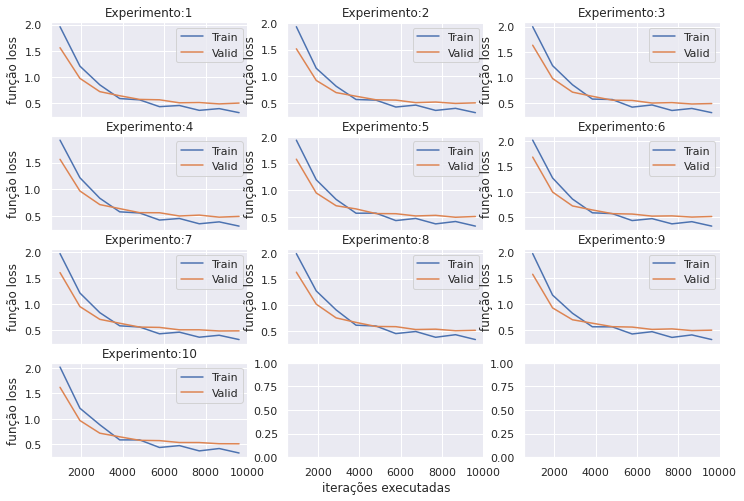

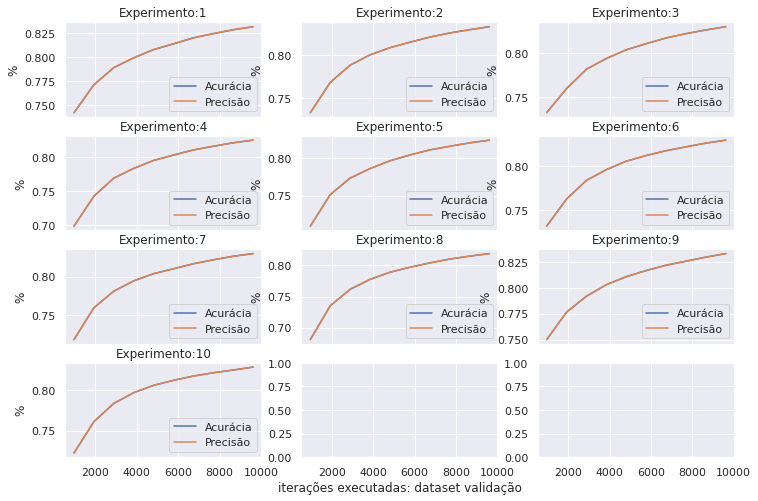

In [9]:
id_planilha = 9
r, c = 4, 3 #r é a quantidade de linhas e colunas para posições dos gráficos de loss
fig, ax =plt.subplots(r,c, figsize=(12, 8), sharex=True)
fig2, ax2 =plt.subplots(r,c, figsize=(12, 8), sharex=True)
corte, i,j=2, 0,0 # posição do gráfico: muda de linha a cada corte, l é a linha que vai imprimir o gráfico
for idx  in range(10):
  file_path = processo.destination_folder + "/"+str(id_planilha)+'/'+str(idx)
  train_loss_list, valid_loss_list, global_steps_list, valid_accuracy, valid_precision = processo.load_metrics(file_path + '/metrics.pt')
  sns.lineplot(x= global_steps_list, y = train_loss_list,  label = 'Train', legend='full', palette=palette, ax=ax[i,j])
  sns.lineplot(x = global_steps_list, y = valid_loss_list, label = 'Valid', legend='full', palette=palette, ax=ax[i,j])
  sns.lineplot(x = global_steps_list, y = valid_accuracy, label = 'Acurácia', legend='full', palette=palette, ax=ax2[i,j])
  sns.lineplot(x = global_steps_list, y = valid_precision, label = 'Precisão', legend='full', palette=palette, ax=ax2[i,j])
  ax[i,j].set_title('Experimento:' + str(idx+1)  )
  ax2[i,j].set_title('Experimento:' + str(idx+1)  )
  ax[i,j].set_ylabel('função loss')
  ax2[i,j].set_ylabel('%')
  #print(valid_loss_list[-1])
  if (idx<corte):
    j+=1
  else:
    corte+=c
    i+=1
    j=0
ax[r-1,1].set_xlabel('iterações executadas')
ax2[r-1,1].set_xlabel('iterações executadas: dataset validação')

# AVALIANDO O MODELO

In [10]:
id_planilha = 9
dataset = 5
gerais=[]
porclasse=[]
file_path = processo.destination_folder + "/"+str(id_planilha)
for idx  in range(10):
  file_path = processo.destination_folder + "/"+str(id_planilha)+'/'+str(idx)
  best_model = BERT(qtd_categories=processo.qtd_categorias).to(processo.device)
  processo.load_checkpoint(file_path + '/model.pt', best_model)
  tokens = processo.tokenizaAmostra(processo.source_folder+str(dataset),soTeste=True)
  X_saida_teste, y_true, y_pred = processo.evaluate(best_model, tokens[2]) #tokens[2] é o dataset de teste
  dctMetricas, dfPorClasse = processo.obtemMetricas(y_true,y_pred)    
  gerais.append(dctMetricas)
  porclasse.append(dfPorClasse)
  del(best_model)
  

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Model loaded from <== ./bertimbau_resp/9/0/model.pt


Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Model loaded from <== ./bertimbau_resp/9/1/model.pt


Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Model loaded from <== ./bertimbau_resp/9/2/model.pt


Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Model loaded from <== ./bertimbau_resp/9/3/model.pt


Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Model loaded from <== ./bertimbau_resp/9/4/model.pt


Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Model loaded from <== ./bertimbau_resp/9/5/model.pt


Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Model loaded from <== ./bertimbau_resp/9/6/model.pt


Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Model loaded from <== ./bertimbau_resp/9/7/model.pt


Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Model loaded from <== ./bertimbau_resp/9/8/model.pt


Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Model loaded from <== ./bertimbau_resp/9/9/model.pt


## PRECISÃO, RECALL, F1-SCORE PARA CADA CLASSE

In [12]:
frame=[]
for i, df in enumerate(porclasse):
  df['classe']= df.index.tolist()
  df['teste']=i
  frame.append(df)

dfMetricas = pd.concat(frame, sort=False)
frame=[]
for classe in range(10):
  dfClasse = dfMetricas[dfMetricas['classe']==str(classe)]
  dfDesc = pd.DataFrame(dfClasse.describe().reset_index().drop(['support','teste'],axis=1).rename(columns={'index':'medida'}))
  dfDesc['classe']=classe
  frame.append(dfDesc)
dfMedidas = pd.concat(frame, sort=False)
dfMedidas = dfMedidas[(dfMedidas['medida']=='mean') | (dfMedidas['medida']=='std')] # (dfMedidas['medida']=='std')
dfMedidas.sort_values(by=['medida','classe']).reset_index().drop('index',axis=1).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
medida,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,std,std,std,std,std,std,std,std,std,std
precision,0.861259,0.845914,0.937029,0.909023,0.87173,0.858287,0.869975,0.957959,0.839297,0.861004,0.0107379,0.0223343,0.00626006,0.00953584,0.00677639,0.0172205,0.0104562,0.00266305,0.0150474,0.00780514
recall,0.8985,0.851759,0.996447,0.865403,0.90102,0.720419,0.894118,0.952113,0.922727,0.794203,0.0152843,0.0172862,0.00245201,0.00953119,0.00873825,0.0191496,0.0133147,0.00727321,0.0163363,0.0128724
f1-score,0.879347,0.848427,0.965815,0.886619,0.886095,0.783084,0.881784,0.955016,0.878805,0.826201,0.00603315,0.00541902,0.00364861,0.00587341,0.00472269,0.0115333,0.0068629,0.00434873,0.00439496,0.0083051
classe,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9


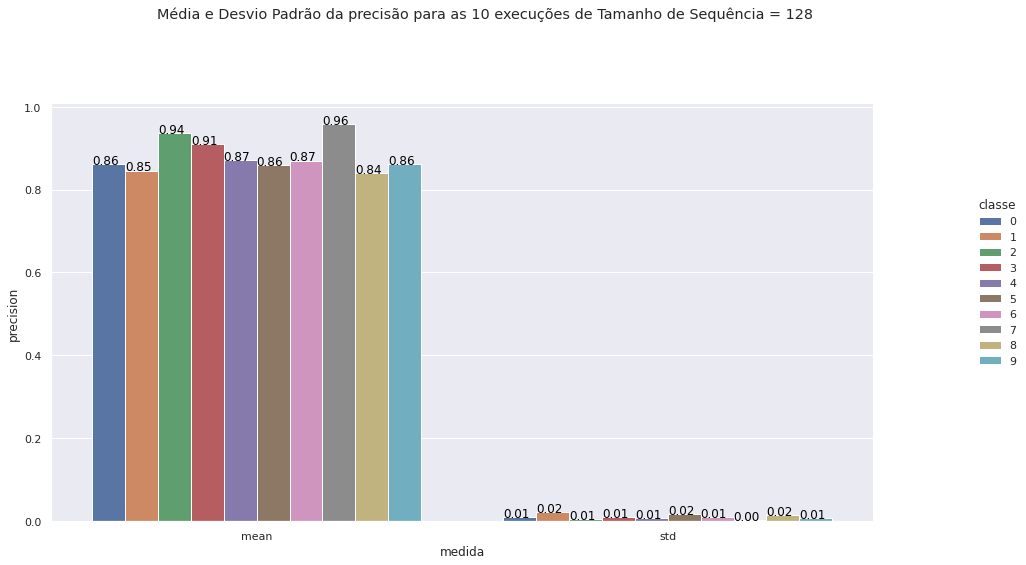

In [13]:

##precisao
g = sns.catplot(x='medida', y='precision', hue='classe', data=dfMedidas, kind='bar', height=8.0)
g.fig.set_size_inches(15,8)
g.fig.subplots_adjust(top=0.81,right=0.86)  
g.fig.suptitle('Média e Desvio Padrão da precisão para as 10 execuções de Tamanho de Sequência = ' +  str(processo.MAX_SEQ_LEN))

ax = g.facet_axis(0,0)
for p in ax.patches:
    ax.text(p.get_x() , 
            p.get_height() , 
           '{0:.2f}'.format(p.get_height()),  
            color='black', 
            rotation='horizontal', 
            )#size='large'

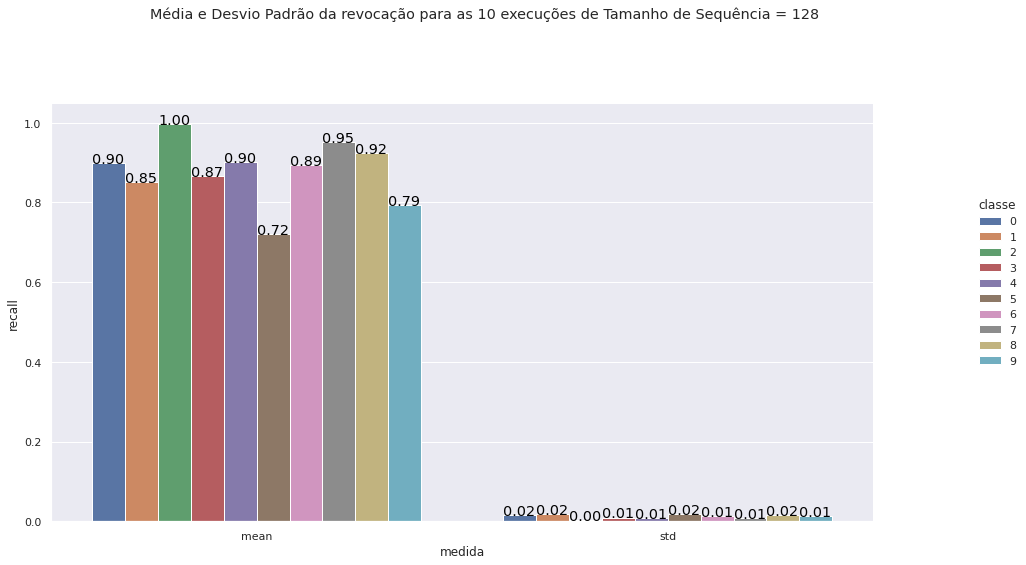

In [14]:
##recall
g = sns.catplot(x='medida', y='recall', hue='classe', data=dfMedidas, kind='bar', height=8.0)
g.fig.set_size_inches(15,8)
g.fig.subplots_adjust(top=0.81,right=0.86)  
g.fig.suptitle('Média e Desvio Padrão da revocação para as 10 execuções de Tamanho de Sequência = ' +  str(processo.MAX_SEQ_LEN))

ax = g.facet_axis(0,0)
for p in ax.patches:
    ax.text(p.get_x() , 
            p.get_height() , 
           '{0:.2f}'.format(p.get_height()),  
            color='black', 
            rotation='horizontal', 
            size='large')

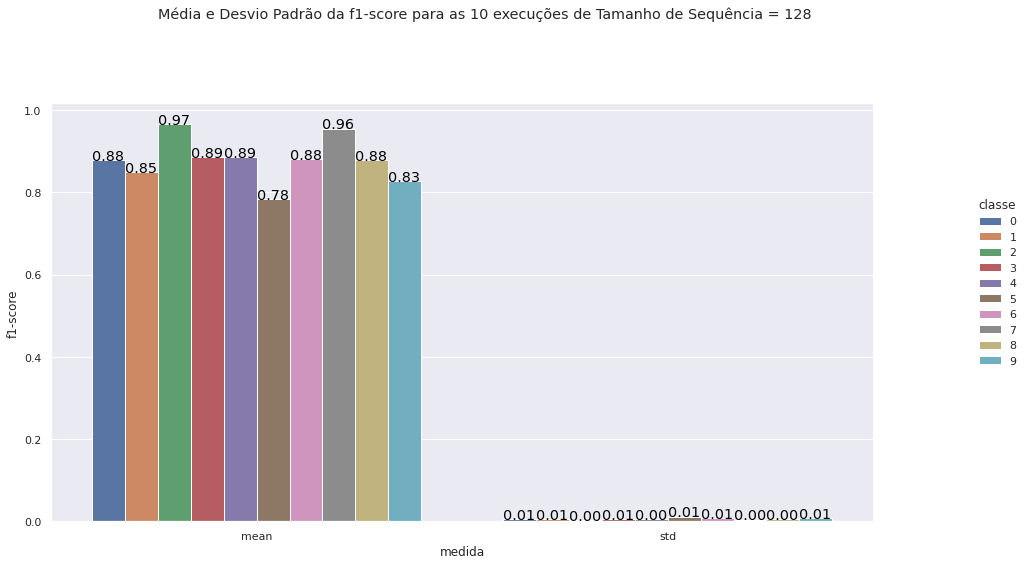

In [15]:
##f1-score
g = sns.catplot(x='medida', y='f1-score', hue='classe', data=dfMedidas, kind='bar', height=8.0)
g.fig.set_size_inches(15,8)
g.fig.subplots_adjust(top=0.81,right=0.86)  
g.fig.suptitle('Média e Desvio Padrão da f1-score para as 10 execuções de Tamanho de Sequência = ' +  str(processo.MAX_SEQ_LEN))

ax = g.facet_axis(0,0)
for p in ax.patches:
    ax.text(p.get_x() , 
            p.get_height() , 
           '{0:.2f}'.format(p.get_height()),  
            color='black', 
            rotation='horizontal', 
            size='large')

## MÉTRICAS GERAIS: ACURÁCIA, ACURÁCIA BALANCEADA, COHEN KAPPA, PRECISÃO REVOCAÇÃO

In [16]:
pd.set_option('display.max_columns', None)
frame=[]
for i, dct in enumerate(gerais):
  df = pd.DataFrame.from_dict(dct, orient='index') #.reset_index().rename(columns={'index':'metrica'})
  df = df.T
  df['experimento']=i
  frame.append(df)
dfGerais = pd.concat(frame, sort=False).reset_index().drop('index',axis=1)
print(dfGerais.describe())

        acuraccy  balanced_accuracy  precision_global  precision_local  \
count  10.000000          10.000000         10.000000        10.000000   
mean    0.882857           0.879671          0.882857         0.881148   
std     0.002415           0.002580          0.002415         0.002607   
min     0.880000           0.876463          0.880000         0.877898   
25%     0.880909           0.877884          0.880909         0.879339   
50%     0.882857           0.879658          0.882857         0.881151   
75%     0.884026           0.880777          0.884026         0.882183   
max     0.887792           0.885242          0.887792         0.886966   

       recall_global  recall_local  f1score_global  f1score_local  \
count      10.000000     10.000000       10.000000      10.000000   
mean        0.882857      0.879671        0.882857       0.879119   
std         0.002415      0.002580        0.002415       0.002572   
min         0.880000      0.876463        0.880000       

In [ ]:
#%%time    
rep = []
id_planilha = 9
dataset = 5
tokens = processo.tokenizaAmostra(source_folder+str(dataset),soTeste=True)
best_model = BERT(qtd_categories=processo.qtd_categorias).to(processo.device)
processo.load_checkpoint(destination_folder+"/"+str(id_planilha) + '/model.pt', best_model)
X_saida_teste, y_true, y_pred = processo.evaluate(best_model, tokens[2]) #tokens[2] é o dataset de teste
dctMetricas, dfPorClasse = processo.obtemMetricas(y_true,y_pred)      

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Model loaded from <== ./bertimbau_resp/9/model.pt


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 1925 samples in 0.003s...
[t-SNE] Computed neighbors for 1925 samples in 0.056s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1925
[t-SNE] Computed conditional probabilities for sample 1925 / 1925
[t-SNE] Mean sigma: 0.299890
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.547104
[t-SNE] KL divergence after 1000 iterations: 0.589578


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


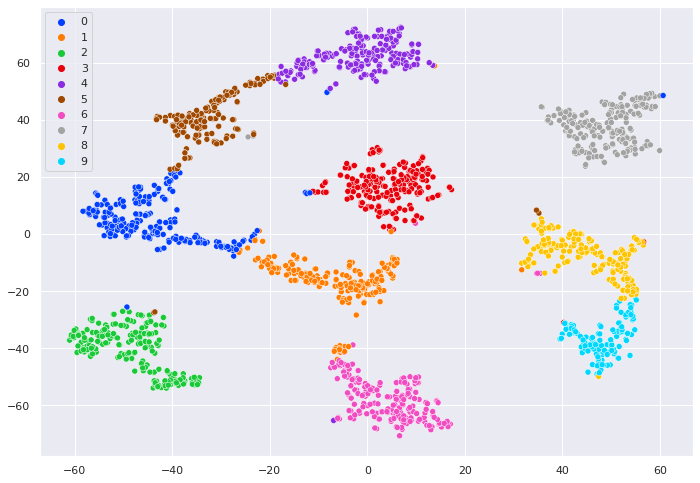

In [ ]:
processo.imprimeGraficosReducaoDimensaoTSNE(X_saida_teste, y_pred)